<a href="https://colab.research.google.com/github/hallpaz/3dsystems21/blob/main/assignments/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 - 3D Graphics Systems - IMPA 2021
## Rendering textured pointclouds and meshes

In [1]:
# Initial Setup
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118    0   118    0     0    651      0 --:--:-- --:--:-- --:--:--   648
100  404k    0  404k    0     0   901k      0 --:--:-- --:--:-- --:--:--  901k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-0t38uv6z
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-0t38uv6z
  Running command git checkout -q 18ce14cd31a2f1c99e16d727e1755156c360453a
     |████████████████████████████████| 645kB 13.3MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86_64.whl size=20506819 sha256=e2ada1175100c75dee2d13c53fe8fe57c0363c89d7a592175e81bb4f6371ada3
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_n3euwf/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



⚠️ ⚠️ ⚠️  If using **Google Colab**, fetch the utils file for plotting image grids:

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-02-02 14:01:14--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-02-02 14:01:14 (25.3 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



In [ ]:
# uncomment and run this line if running locally
# from utils import image_grid

# Part 1 - Loading a textured mesh and visualizing its texture map

0.1 Download a textured mesh set of files. The .obj describes the mesh structure; The .mtl describes its material and the image (.png) is a texture map.

In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2021-02-02 14:01:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2021-02-02 14:01:15 (9.67 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2021-02-02 14:01:15--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

1.1 Load the mesh data using the function `load_objs_as_meshes`. It takes a list of paths to one or multiple .obj file and returns a Meshes object.

1.2 Visualize the texture map loaded with the mesh. The texture data can be obtained from the "other attributes"

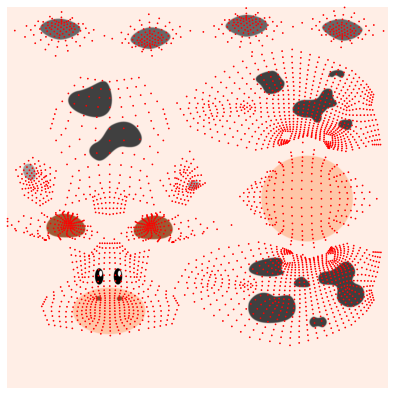

In [6]:
##############################################################################
# Code for 1.1-1.2.
##############################################################################
# load meshes object
mesh = load_objs_as_meshes(["data/cow_mesh/cow.obj"], device=device)

plt.figure(figsize=(7,7))
# plot texture map as image
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.grid("off");
plt.axis("off");

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

# Part 2 - Rendering a Mesh

## 2. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest. We will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **phong shading**.

In [7]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

## 3. Render the mesh

2.0 Use the `renderer` function to render the mesh. It takes a Meshes object and returns a tensor that you can interpret as an image.

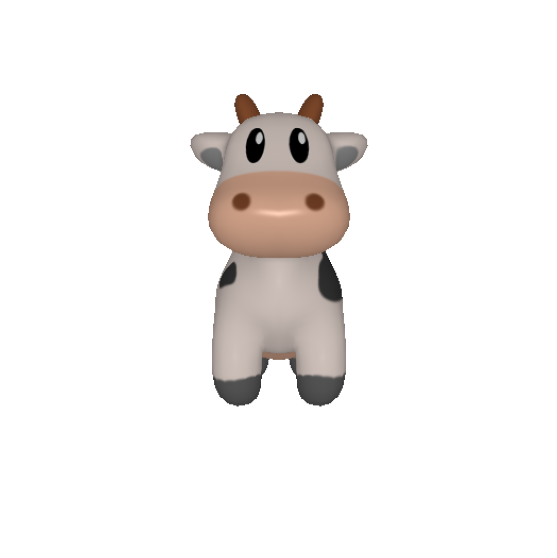

In [8]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [ ]:
from pytorch3d.renderer import ( 
    SoftGouraudShader,
    SoftSilhouetteShader,
    HardFlatShader
)

2.1 Move the light by changing its location coordinates and render the scene again. You don't need to recreate the renderer to specify a new light setting. When you call your renderer, you can pass a **lights parameter**: `renderer(mesh, lights=newlights)`


2.2 Experiment to define a new renderer using the `HardFlatShader` and render the mesh. 

2.3 - We can also change the material of a batch of meshes. Define a new `Material` object and experiment changing the **material reflectance** properties of the mesh by specifying new values for the attributes `specular_color` and `shininess`. Again, you can pass a materials parameter as you call your renderer: `renderer(mesh, material=newmaterial)`


#### **You are going to learn more about illumination models in a few weeks. For now, just try to run these experiments to get used to the APIs available in PyTorch3D and write your comments based on your observations.**


In [ ]:
##############################################################################
# Code for 2.1-2.3.
##############################################################################

In [ ]:
# CODE
gouraud = MeshRenderer(renderer.rasterizer, SoftGouraudShader(device=device, cameras=cameras, lights=lights))
flat = MeshRenderer(renderer.rasterizer, HardFlatShader(device=device, cameras=cameras, lights=lights))
images = flat(mesh, cameras=cameras, lights=lights)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

### Extra
E.1 Compute the estimated normals for each vertex of the mesh and render a normal map using the `SoftGouraudShader`.

In [ ]:
##############################################################################
# Code for E.1
##############################################################################

In [21]:
# testing the Gouraud Shader
verts, faces_idx, _ = load_obj("data/cow_mesh/cow.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.rand(verts.size())[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))
# Create a Meshes object
newmesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)],
    textures=textures
)

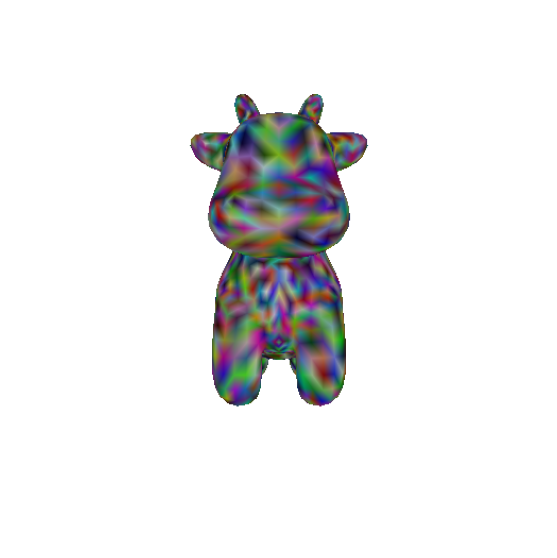

In [22]:
images = gouraud(newmesh, cameras=cameras, lights=lights)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

## Parte 3 - Moving the scene

In [42]:
from pytorch3d.transforms import Transform3d, Rotate, Translate



3.1 Check the documentation for the function `look_at_view_transform`. It gives us an intuitive way to define a virtual camera, returning a rotation matrix and translation vector to be applied on the scene. Define a new camera and render the scene from another viewpoint by passing the parameter `cameras` to your renderer: `renderer(mesh, cameras=newcamera)` .

3.2 In addition to moving the camera, we can move the object too, by applying a transformation to its vertices. Rotate the by 90 degrees around the vertical axis (Y) and render the scene.

3.3 Use any configuration of camera and object transformations to render a scene with two equal objects facing each other as in the figure below.

In [11]:
# give the start code to create a batch of 2 meshes
# show a reference image

In [ ]:
##############################################################################
# Code for 3.1-3.3.
##############################################################################

## Part 4. Batched Rendering - No Exercises

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**. 
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


In [32]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

In [33]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

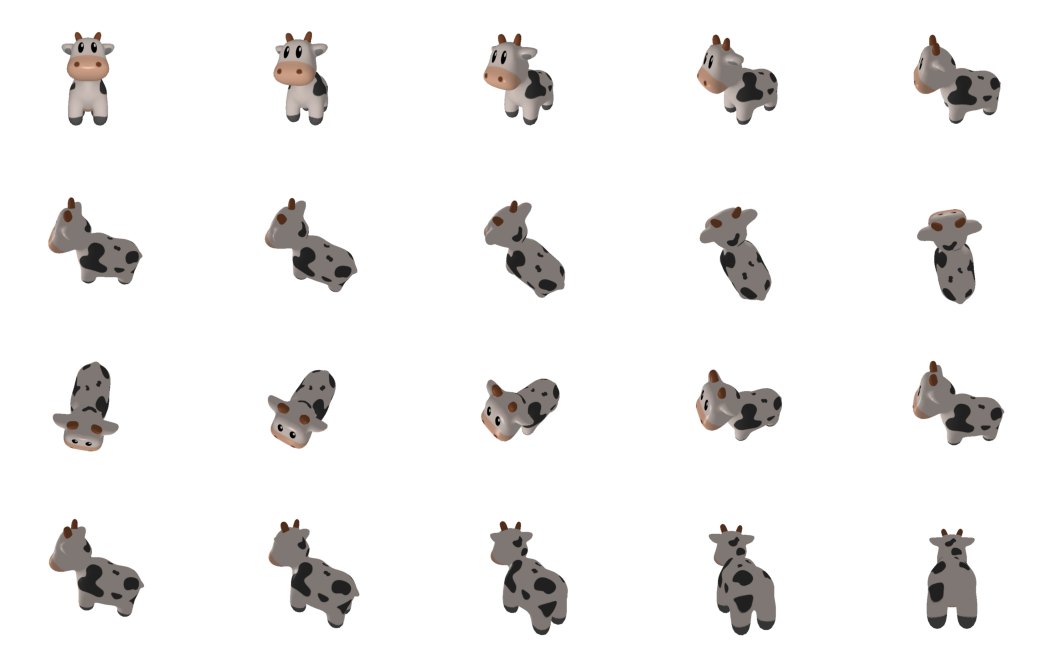

In [34]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

## Part 5. Rendering Point Clouds

In [ ]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

In [ ]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
pcrenderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

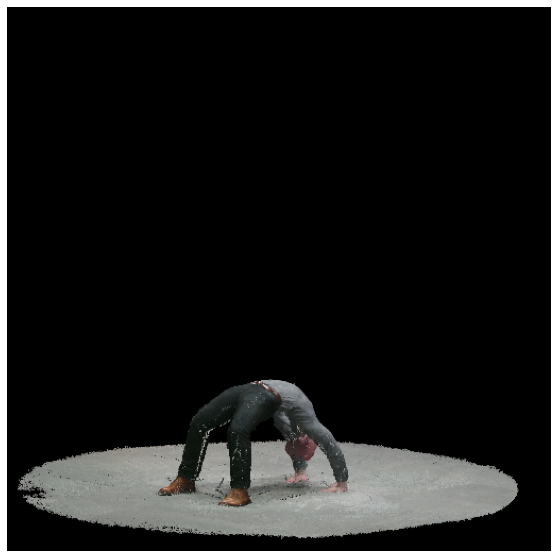

In [ ]:
images = pcrenderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

## Part 6. Plotly visualization 
If you only want to visualize a mesh, you don't really need to use a differentiable renderer - instead we can plot Meshes with plotly.

In [38]:
verts, faces_idx, _ = load_obj("data/cow_mesh/cow.obj")
faces = faces_idx.verts_idx
# use Plotly's default colors (no texture)
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)]
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

4.1 We can plot textured meshes using TexturesVertex to define a texture for the rendering (if you did the exercise Extra.1, it's the same ideia). Create a TexturesVertex object, create a new Meshes instance using these textures and render a textured mesh with plotly. You don't need to define a complicated textures tensor, it's "ok" to use the same color to all vertices.

### Extra
E.2 Use the texture UV coordinates defined for the mesh to sample the colors in the texture map (the image).

In [37]:


# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)],
    textures=textures
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    }
})
fig.show()

In [41]:
# create a batch of meshes, and offset one to prevent overlap
mesh_batch = Meshes(
    verts=[verts.to(device), (verts + torch.tensor([2, 0, 0])).to(device)],   
    faces=[faces.to(device), faces.to(device)]
)

# plot mesh batch in the same trace
fig = plot_scene({
    "subplot1": {
        "cow_mesh_batch": mesh_batch
    }
})
fig.show()

In [48]:
# plot batch of meshes in different traces
fig = plot_scene({
    "subplot1": {
        "cow_mesh1": mesh_batch[0],
        "cow_mesh2": mesh_batch[1]
    }
})
fig.show()

In [49]:
# plot batch of meshes in different subplots
fig = plot_scene({
    "subplot1": {
        "cow_mesh1": mesh_batch[0]
    },
    "subplot2":{
        "cow_mesh2": mesh_batch[1]
    }
})
fig.show()

For batches, we can also use `plot_batch_individually` to avoid constructing the scene dictionary ourselves.

In [50]:
# extend the batch to have 4 meshes
mesh_4 = mesh_batch.extend(2)

# visualize the batch in different subplots, 2 per row
fig = plot_batch_individually(mesh_4)
# we can update the figure height and width
fig.update_layout(height=1000, width=500)
fig.show()

We can also modify the axis arguments and axis backgrounds in both functions. 

In [51]:
fig2 = plot_scene({
    "cow_plot1": {
        "cows": mesh_batch
    }
},
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig2.show()

In [ ]:
fig3 = plot_batch_individually(
    mesh_4, 
    ncols=2,
    subplot_titles = ["cow1", "cow2", "cow3", "cow4"], # customize subplot titles
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    axis_args=AxisArgs(showgrid=True))
fig3.show()

## 8. Conclusion
In this tutorial we learnt how to **load** a textured mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, and modify several components of the rendering pipeline. We also learned how to render Meshes in Plotly figures.